In [4]:
import tweepy
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv('train.csv')
df = df.drop(['textID','selected_text'], axis=1)
df.head()


,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [6]:
df.isnull().sum()


text         1
sentiment    0
dtype: int64

In [6]:
df.dropna(axis=0, inplace=True)
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [9]:
df['length'] = df['text'].fillna('').apply(lambda x: len(x.split()))


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt  # Just in case you're also using plt later



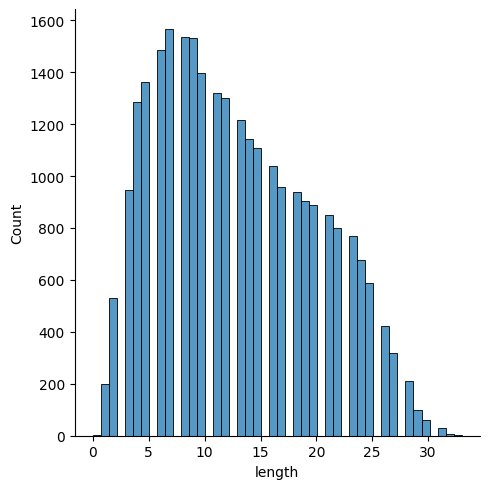

In [11]:
sns.displot(df['length'])


<Axes: xlabel='count', ylabel='sentiment'>

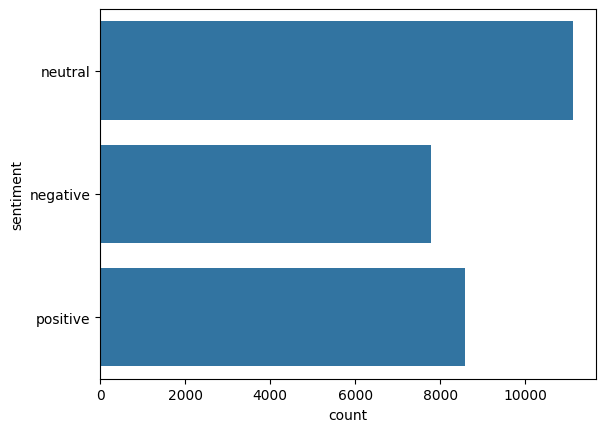

In [12]:
sns.countplot(df['sentiment'])

In [12]:
# df.sentiment = df.sentiment.replace({'positive': 2, 'neutral': 1, 'negative': 0})

In [13]:
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
import string

class TweetCleaner:
    def __init__(self):
        self.tokenizer = TweetTokenizer(strip_handles=False, reduce_len=True)

    def remove_urls(self, text):
        """Remove URLs from text"""
        url_pattern = r'https?://\S+|www\.\S+'
        return re.sub(url_pattern, '', text)

    def remove_mentions(self, text):
        """Remove @ mentions from text"""
        mention_pattern = r'@\w+'
        return re.sub(mention_pattern, '', text)

    def clean_hashtags(self, text):
        """Remove # symbol but keep the hashtag text"""
        return re.sub(r'#(\w+)', r'\1', text)

    def remove_punctuation_and_numbers(self, text):
        """Remove punctuation and numbers"""
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text

    global remove_stopwords
    def remove_stopwords(self, text):
        """Remove stopwords from text"""
        stop_words = set(stopwords.words('english'))-negation_words
        tokens = self.tokenizer.tokenize(text)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        stemmer = PorterStemmer()
        stem_token = [stemmer.stem(word) for word in filtered_tokens]
        return ' '.join(stem_token)

    def handle_negation(self, text):
        """
        Add NEG_ prefix to words that follow a negation word until the next punctuation.

        Args:
            text (str): Input text that has already been cleaned

        Returns:
            str: Text with NEG_ prefix added to words after negation words
        """

        global negation_words
        negation_words = {'no', 'not', 'never', 'none', "n't", 'cannot', 'cant',
                             'neither', 'nor', 'nothing', 'nowhere', 'nobody', 'hardly',
                             'barely', 'scarcely', 'rarely'}

        text = remove_stopwords(self, text)
        words = text.split()
        modified_words = []
        negation = False

        for i, word in enumerate(words):
            # Check if current word is a negation
            if word in negation_words or word.endswith("n't"):
                negation = True
                modified_words.append(word)
                continue

            # Check if we should stop negation (punctuation or 3 words after negation)
            if any(p in word for p in '.!?;:') or (negation and i > 2):
                negation = False

            # Add NEG_ prefix if we're in negation state
            if negation:
                modified_words.append('NEG_' + word)
            else:
                modified_words.append(word)

        return ' '.join(modified_words)

    def clean_tweet(self, tweet):
        """Clean tweet text using all preprocessing steps"""
        tweet = tweet.lower()

        # Apply each cleaning step
        tweet = self.remove_urls(tweet)
        tweet = self.remove_mentions(tweet)
        tweet = self.clean_hashtags(tweet)
        tweet = self.remove_punctuation_and_numbers(tweet)
        tweet = self.handle_negation(tweet)

        return tweet

# # Example usage
# if __name__ == "__main__":
#     cleaner = TweetCleaner()

#     # Test tweet with various elements to clean
#     sample_tweets = [
#         "Check out this link https://example.com! @user #Python #coding is fun 123",
#         "RT @developer: Just learned #DataScience at www.school.com - it's amazing!!!",
#         "My temp is 98.6° @doctor #Health #Wellness",
#         "@friend This is sooooo coooool! #awesome #technology https://t.co/123"
#     ]

#     print("Original vs Cleaned Tweets:\n")
#     for tweet in sample_tweets:
#         cleaned = cleaner.clean_tweet(tweet)
#         print(f"Original: {tweet}")
#         print(f"Cleaned:  {cleaned}")
#         print()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/snigdhahalder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df['clean_text'] = df['text'].fillna('').apply(cleaner.clean_tweet)


In [16]:
X = df['clean_text']
y = df['sentiment']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [19]:
X_train.shape

(21984, 18971)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.709114062215754


In [21]:
confusion_matrix(y_test, y_pred)

array([[ 956,  498,  108],
       [ 256, 1631,  343],
       [  61,  333, 1311]])

<Axes: >

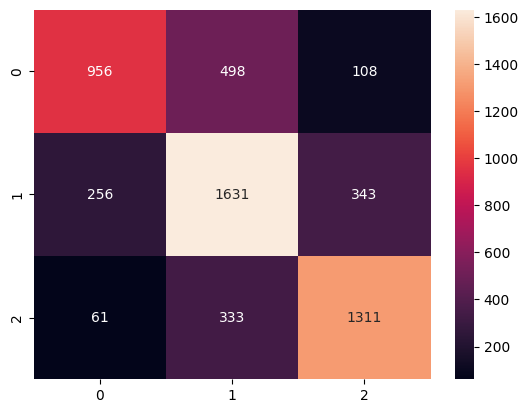

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d")

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.75      0.61      0.67      1562
     neutral       0.66      0.73      0.70      2230
    positive       0.74      0.77      0.76      1705

    accuracy                           0.71      5497
   macro avg       0.72      0.70      0.71      5497
weighted avg       0.71      0.71      0.71      5497



In [24]:
text = 'it is a  not good day but i am sad'
cleaned = cleaner.clean_tweet(text)
vector = tfidf_vectorizer.transform([cleaned])
prediction = rf_classifier.predict(vector)
print(prediction)

['negative']


In [25]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1)
dt_classifier.fit(X_train, y_train)

dt_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, dt_pred)
print(f"Accuracy: {accuracy}")
confusion_matrix(y_test, dt_pred)

Accuracy: 0.6567218482808804


array([[ 975,  441,  146],
       [ 423, 1406,  401],
       [ 126,  350, 1229]])

In [26]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

gnb_pred = gnb.predict(X_test.toarray())
accuracy = accuracy_score(y_test, gnb_pred)
print(f"Accuracy: {accuracy}")
confusion_matrix(y_test, gnb_pred)

Accuracy: 0.4449699836274331


array([[1077,  168,  317],
       [1063,  293,  874],
       [ 429,  200, 1076]])

In [27]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence
lr_classifier.fit(X_train, y_train)

lr_pred = lr_classifier.predict(X_test)
accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {accuracy}")

Logistic Regression Accuracy: 0.6931053301800982


In [28]:
import pickle

# Replace these with your actual model and vectorizer variables
# Example: model = RandomForestClassifier(), vectorizer = TfidfVectorizer()

# Save Random Forest model
with open("random_forest_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open("text_vectorizer.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)
